# Class 4: Multinomial Models and Vector Models
For this class we will use the songs dataset from Kaggle. As we have already pre-processed this data in the problem set, I will import the objects from the problems set instead of re-running the code. 

```
conda install anaconda::statsmodels
```

In [1]:
#Load the data
#I will keep the dataframe with the tokens.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [3]:
df = pd.read_pickle("Text_as_data/Data/Class3/Songs.pkl")

## Discriminating Words

### Fightin' Words
We can go back to what we did last time comparing artists using fighting words

We will use an implementation of fightin' words done by Jack Hessel and available [https://github.com/jmhessel/FightingWords/tree/master](on GitHub). In the next cell we copy and paste the code for python 3 (we could also have imported the file). 


In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df=0.005,
                max_df=.9, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

Let's focus our attention on the description of the function. In this case, the author did not create a specific file with the documentation, but wrote a brief series of instructions inside the definition of the function:

```
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
```

In [5]:
#The function require l1 and l2 to be lists of strings. Now our data are in the form of dataframes

#Let's compare the Foo Fighters and the Beatles
foo=[]
beatles=[]

#Update these two empy lists with the tokens in the dataset
for index, row in df.iterrows():
    if row['artist']=='Foo Fighters':
        foo.append(" ".join(row['tokens_simple']))
    elif row['artist']=='The Beatles':
        beatles.append(" ".join(row['tokens_simple']))

In [6]:
#Print the first song
foo[0] 

'life search come lead satisfie close close prize end rope night long dream day     come away leave feeling feel feel come life ghost     calm resist delicate wrist twist hold lose grip find need reason bleed hide sleeve hide sleeve     let waste love hate taste weight keepin let waste love hate taste weight keepin     find believer believe deceive knee close open wide let inside hide hide     let waste love hate taste weight keepin let waste love hate taste weight keepin     life search come lead satisfie close close prize end rope     night long dream day come away leave feeling feel feel come life ghost             let waste love hate taste weight keepin let waste love hate taste weight keepin    '

In [7]:
scores = bayes_compare_language(foo, beatles, ngram = 1, prior=.01, cv = None)

Vocab size is 1103
Comparing language...


In [8]:
#features that characterize the second group (The Beatles)
print([x for x in scores if x[1] < -1.96])

[('love', -12.594012834134139), ('yeah', -9.478892769212795), ('baby', -7.1744498629488564), ('girl', -7.047869031358014), ('cry', -5.97695750497295), ('tell', -5.46541185970856), ('hey', -5.403942403024599), ('man', -5.352079981059196), ('want', -4.89830206891787), ('know', -4.832562214568193), ('hello', -4.491620457452968), ('ah', -4.43454881120844), ('long', -4.409019712050299), ('honey', -4.3531880526873055), ('night', -4.112165210832256), ('money', -3.9562786818902724), ('dance', -3.8938563213592303), ('yes', -3.856512812827571), ('need', -3.7603637936337924), ('little', -3.6457776669403996), ('cause', -3.6093203150185937), ('roll', -3.5549842083769687), ('sleep', -3.499344716594324), ('sun', -3.4578808440879256), ('lonely', -3.4049699587426576), ('child', -3.4049699587426576), ('bring', -3.2451239146266073), ('fun', -3.177689307154805), ('send', -3.1143951263468788), ('mm', -3.0965535901594623), ('belong', -2.9135538597305852), ('happy', -2.89034791797856), ('everybody', -2.85543

In [9]:
#features that characterize the first group (Foo Fighters)
print([x for x in scores if x[1] > 1.96])

[('wow', 1.9611373336958515), ('choose', 1.9611373336958515), ('fear', 1.9611373336958515), ('fact', 1.9611373336958515), ('piece', 1.9611373336958515), ('color', 1.9611373336958515), ('room', 1.9888620570565092), ('la', 1.9901233580590072), ('talk', 2.0061318244837003), ('like', 2.0222024303676562), ('chorus', 2.0273970921198465), ('beat', 2.100501716395555), ('yea', 2.1031386566151666), ('future', 2.1031386566151666), ('freak', 2.1031386566151666), ('new', 2.112782213633294), ('blame', 2.1154642201409244), ('lay', 2.1154642201409244), ('forever', 2.1554236672845555), ('light', 2.1608540896276565), ('sister', 2.207486223775663), ('ground', 2.2179491994875384), ('mountain', 2.2285532180226033), ('choke', 2.2285532180226033), ('ready', 2.2285532180226033), ('damn', 2.2285532180226033), ('bridge', 2.2713232200837026), ('learn', 2.2931805774150105), ('secret', 2.323606207248927), ('throw', 2.323606207248927), ('fight', 2.340779382652976), ('breath', 2.340779382652976), ('break', 2.3594839

### OLS Regressions
Do the coefficients one by one, see which works best. First we need to create the document-feature matrix.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=None,
                             lowercase=False,
                             min_df=0.005,
                             max_df=.9,
                             max_features=10000,
                             binary=True
                             )

X = vectorizer.fit_transform(df.loc[(df['artist'] == 'The Beatles') | (df['artist'] == 'Foo Fighters')]['tokens_simple'].apply(lambda tokens: " ".join(tokens)))

#Create the vectorized version of the data
#keep only two artists
#use scikit learn to handle sparse matrices
#define a function that runs a regression for a single variable and stores the coefficient and t-stat
#run the function for every variable
#See which variables have high

In [11]:
#Create the outcome variable. We will create a variable that takes value 1 if the artist is "The Beatles" and value 0 otherwise. We will also filter to only include songs by The Beatles or by Eminem.
Y = df.loc[(df['artist'] == 'The Beatles') | (df['artist'] == 'Foo Fighters')]['artist'].apply(lambda x: 1 if x == 'The Beatles' else 0)

We are assigning value 1 to The Beatles, therefore the variables with a positive coefficient will tend to be associated with The Beatles.

In [12]:
print(X.shape, Y.shape)

(320, 1103) (320,)


We will begin by using `statsmodels`, a popular package to run regressions. As the X matrix is sparse, we need to make sure to make it "dense" before running the regression, because statsmodels does not support this data format.

In [13]:
#We create a new column, dense, and add a constant. 
X_with_const = sm.add_constant(X[:,0].toarray())

# Create the model
model = sm.OLS(Y, X_with_const)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 artist   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.527
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.113
Time:                        20:57:50   Log-Likelihood:                -228.95
No. Observations:                 320   AIC:                             461.9
Df Residuals:                     318   BIC:                             469.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5597      0.028     20.108      0.0

We have one observation per song. This word is not significantly correlated with any of the two categories.

In [14]:
vectorizer.get_feature_names_out()[0]

'abuse'

In [15]:
results.params

const    0.559748
x1      -0.559748
dtype: float64

In [16]:
results.bse

const    0.027838
x1       0.352122
dtype: float64

We now need to perform this operation for all other features, store the results and then see which ones stand out. 

In [17]:
stored_coefficients=[]

for i in range(0, X.shape[1]):
    X_with_const = sm.add_constant(X[:,i].toarray())

    # Create the model
    model = sm.OLS(Y, X_with_const)

    # Fit the model
    results = model.fit()
    
    coef = results.params.iloc[1]
    se = results.bse.iloc[1]
    t_stat = results.tvalues.iloc[1]
    feature_name = vectorizer.get_feature_names_out()[i] #for simplicity, we can store the feature name as well

    # Append the coefficient, its standard error, and the t-statistic
    stored_coefficients.append([coef, se, t_stat, feature_name])
    
del X_with_const, results, coef, se, t_stat, feature_name #Delete the objects we don't need

In [18]:
stored_coefficients = pd.DataFrame(stored_coefficients, columns=['Coefficient', 'Standard Error', 'T-Statistic', 'Feature_name'])

In [19]:
stored_coefficients.sort_values(by='T-Statistic', ascending=False).head(10)

,Coefficient,Standard Error,T-Statistic,Feature_name
560,0.282135,0.057497,4.906979,love
1098,0.437966,0.100868,4.341976,yes
41,0.297708,0.079965,3.722958,baby
388,0.277339,0.079393,3.493231,girl
11,0.411332,0.118700,3.465296,ah
968,0.213816,0.063774,3.352732,tell
789,0.459547,0.150733,3.048743,sad
652,0.181988,0.060120,3.027085,oh
1094,0.198386,0.071961,2.756855,yeah
492,0.456592,0.166559,2.741326,john


In [20]:
stored_coefficients.sort_values(by='T-Statistic', ascending=True).head(10)

,Coefficient,Standard Error,T-Statistic,Feature_name
122,-0.544354,0.108291,-5.026777,burn
1034,-0.327468,0.072661,-4.506780,wait
1047,-0.579805,0.137327,-4.222070,waste
991,-0.507003,0.133212,-3.805987,tired
318,-0.330171,0.092354,-3.575070,fall
433,-0.265180,0.074650,-3.552312,head
1015,-0.316123,0.089878,-3.517229,turn
421,-0.412804,0.118684,-3.478165,hang
1048,-0.365100,0.105909,-3.447313,watch
295,-0.308330,0.095497,-3.228682,end


In [21]:
stored_coefficients.columns

Index(['Coefficient', 'Standard Error', 'T-Statistic', 'Feature_name'], dtype='object')

### Lasso
Let's know use a different approach. Here we will add all features at once, and let the algorithm choose a subset of them based on how well they can predict the outcome variable.

We will be using the [Lasso model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) from scikit-learn. 

In [22]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(X, Y)

LogisticRegression(penalty='l1', solver='liblinear')

In [23]:
coefficients = pd.DataFrame(log.coef_).T
feature_names_df = pd.DataFrame(vectorizer.get_feature_names_out(), columns=['Feature'])
full_df = pd.concat([feature_names_df, coefficients], axis=1)


In [24]:
full_df.sort_values(by=0, ascending=False)

,Feature,0
11,ah,1.940044
789,sad,1.611730
560,love,1.461506
1098,yes,1.131869
643,night,0.741708
...,...,...
318,fall,-1.420247
122,burn,-1.602275
813,secret,-1.671230
890,soul,-1.856084


In [25]:
full_df.sort_values(by=0, ascending=True)

,Feature,0
1047,waste,-1.981425
890,soul,-1.856084
813,secret,-1.671230
122,burn,-1.602275
318,fall,-1.420247
...,...,...
643,night,0.741708
1098,yes,1.131869
560,love,1.461506
789,sad,1.611730


In [26]:
# We can run a lasso 
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_normalized = scaler.fit_transform(X)

Y1 = Y*100

alpha = 1  
lasso = Lasso(alpha=alpha, fit_intercept=True)  
lasso.fit(X_normalized, Y1)

Lasso(alpha=1)

In [27]:
len(lasso.coef_)

1103

In [28]:
lasso.coef_

array([-0.        ,  0.        ,  1.03166864, ...,  0.        ,
       -0.        ,  0.        ])

In [29]:
coefficients_lasso = pd.DataFrame(lasso.coef_)
feature_names_df = pd.DataFrame(vectorizer.get_feature_names_out(), columns=['Feature'])
full_df_lasso = pd.concat([feature_names_df, coefficients_lasso], axis=1)

In [30]:
full_df_lasso.sort_values(by=0, ascending=True)

,Feature,0
122,burn,-7.695461
815,sell,-5.854003
318,fall,-5.792588
918,stick,-5.599439
421,hang,-4.925045
...,...,...
11,ah,2.676105
635,near,2.759698
1098,yes,2.777382
41,baby,3.068332


In [31]:
full_df_lasso.sort_values(by=0, ascending=False)

,Feature,0
560,love,5.718984
41,baby,3.068332
1098,yes,2.777382
635,near,2.759698
11,ah,2.676105
...,...,...
421,hang,-4.925045
918,stick,-5.599439
318,fall,-5.792588
815,sell,-5.854003


## Vector Space Model

### Distance and Cosine Similarity
Let's now use the document-feature matrix to calculate cosine similarity between songs.

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X)
similarity_matrix.shape

(320, 320)

In [33]:
similarity_matrix[:4,:4]

array([[1.        , 0.1       , 0.07905694, 0.11858541],
       [0.1       , 1.        , 0.07905694, 0.11858541],
       [0.07905694, 0.07905694, 1.        , 0.125     ],
       [0.11858541, 0.11858541, 0.125     , 1.        ]])

Here, for example, we see a submatrix with the similarity scores for the first four songs in our dataset. Notice that the diagonal contains 1s, which are the highest values, given that they represent the similarity between a song and itself. Additionally, observe how the scores are symmetric.

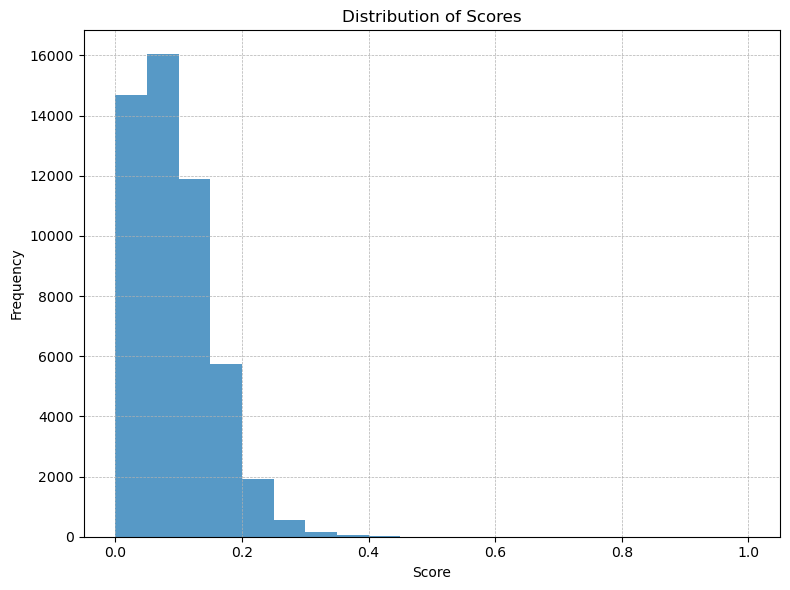

In [34]:
upper_triangular_indices = np.triu_indices_from(similarity_matrix, k=1)
scores = similarity_matrix[upper_triangular_indices]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=20, alpha=0.75)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
vectorizer = CountVectorizer(tokenizer=None,
                             lowercase=False,
                             min_df=0.01,
                             max_df=.9,
                             max_features=10000,
                             binary=False
                             )

X = vectorizer.fit_transform(df['tokens_simple'].apply(lambda tokens: " ".join(tokens)))


In [36]:
#Similarity between Chiquitita and Bang
cosine_similarity(X[7,:], X[3,:])

array([[0.13146844]])

In [37]:
#Similarity between Bang-A-Boomerang and Bang (basically the same song)
cosine_similarity(X[4,:], X[3,:])


array([[1.]])

### K-means clustering
Apply to songs

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [39]:
df2 = df.loc[(df['artist'] == 'The Beatles') | (df['artist'] == 'Foo Fighters')]
df2= df2.reset_index(drop=True)

X = vectorizer.fit_transform(df2['tokens_simple'].apply(lambda tokens: " ".join(tokens)))


In [40]:
X = X.todense()
X = X / X.sum(axis=1)
X = np.asarray(X)


In [41]:
clusters = KMeans(n_clusters=2, n_init="auto", random_state=10)
cluster_labels = clusters.fit_predict(X)
cluster_labels = pd.DataFrame(cluster_labels)


In [42]:
merged_df = df2.merge(cluster_labels, left_index=True, right_index=True)
merged_df=merged_df.sort_values(0, ascending=False)


In [43]:
clusters = KMeans(n_clusters=10, n_init="auto", random_state=10)
cluster_labels = clusters.fit_predict(X)
cluster_labels = pd.DataFrame(cluster_labels, columns=['cluster'])

merged_df = df2.merge(cluster_labels, left_index=True, right_index=True)
merged_df = merged_df.sort_values('cluster', ascending=False)
merged_df['text'] = merged_df['tokens_simple'].apply(' '.join)


`conda install wordcloud`

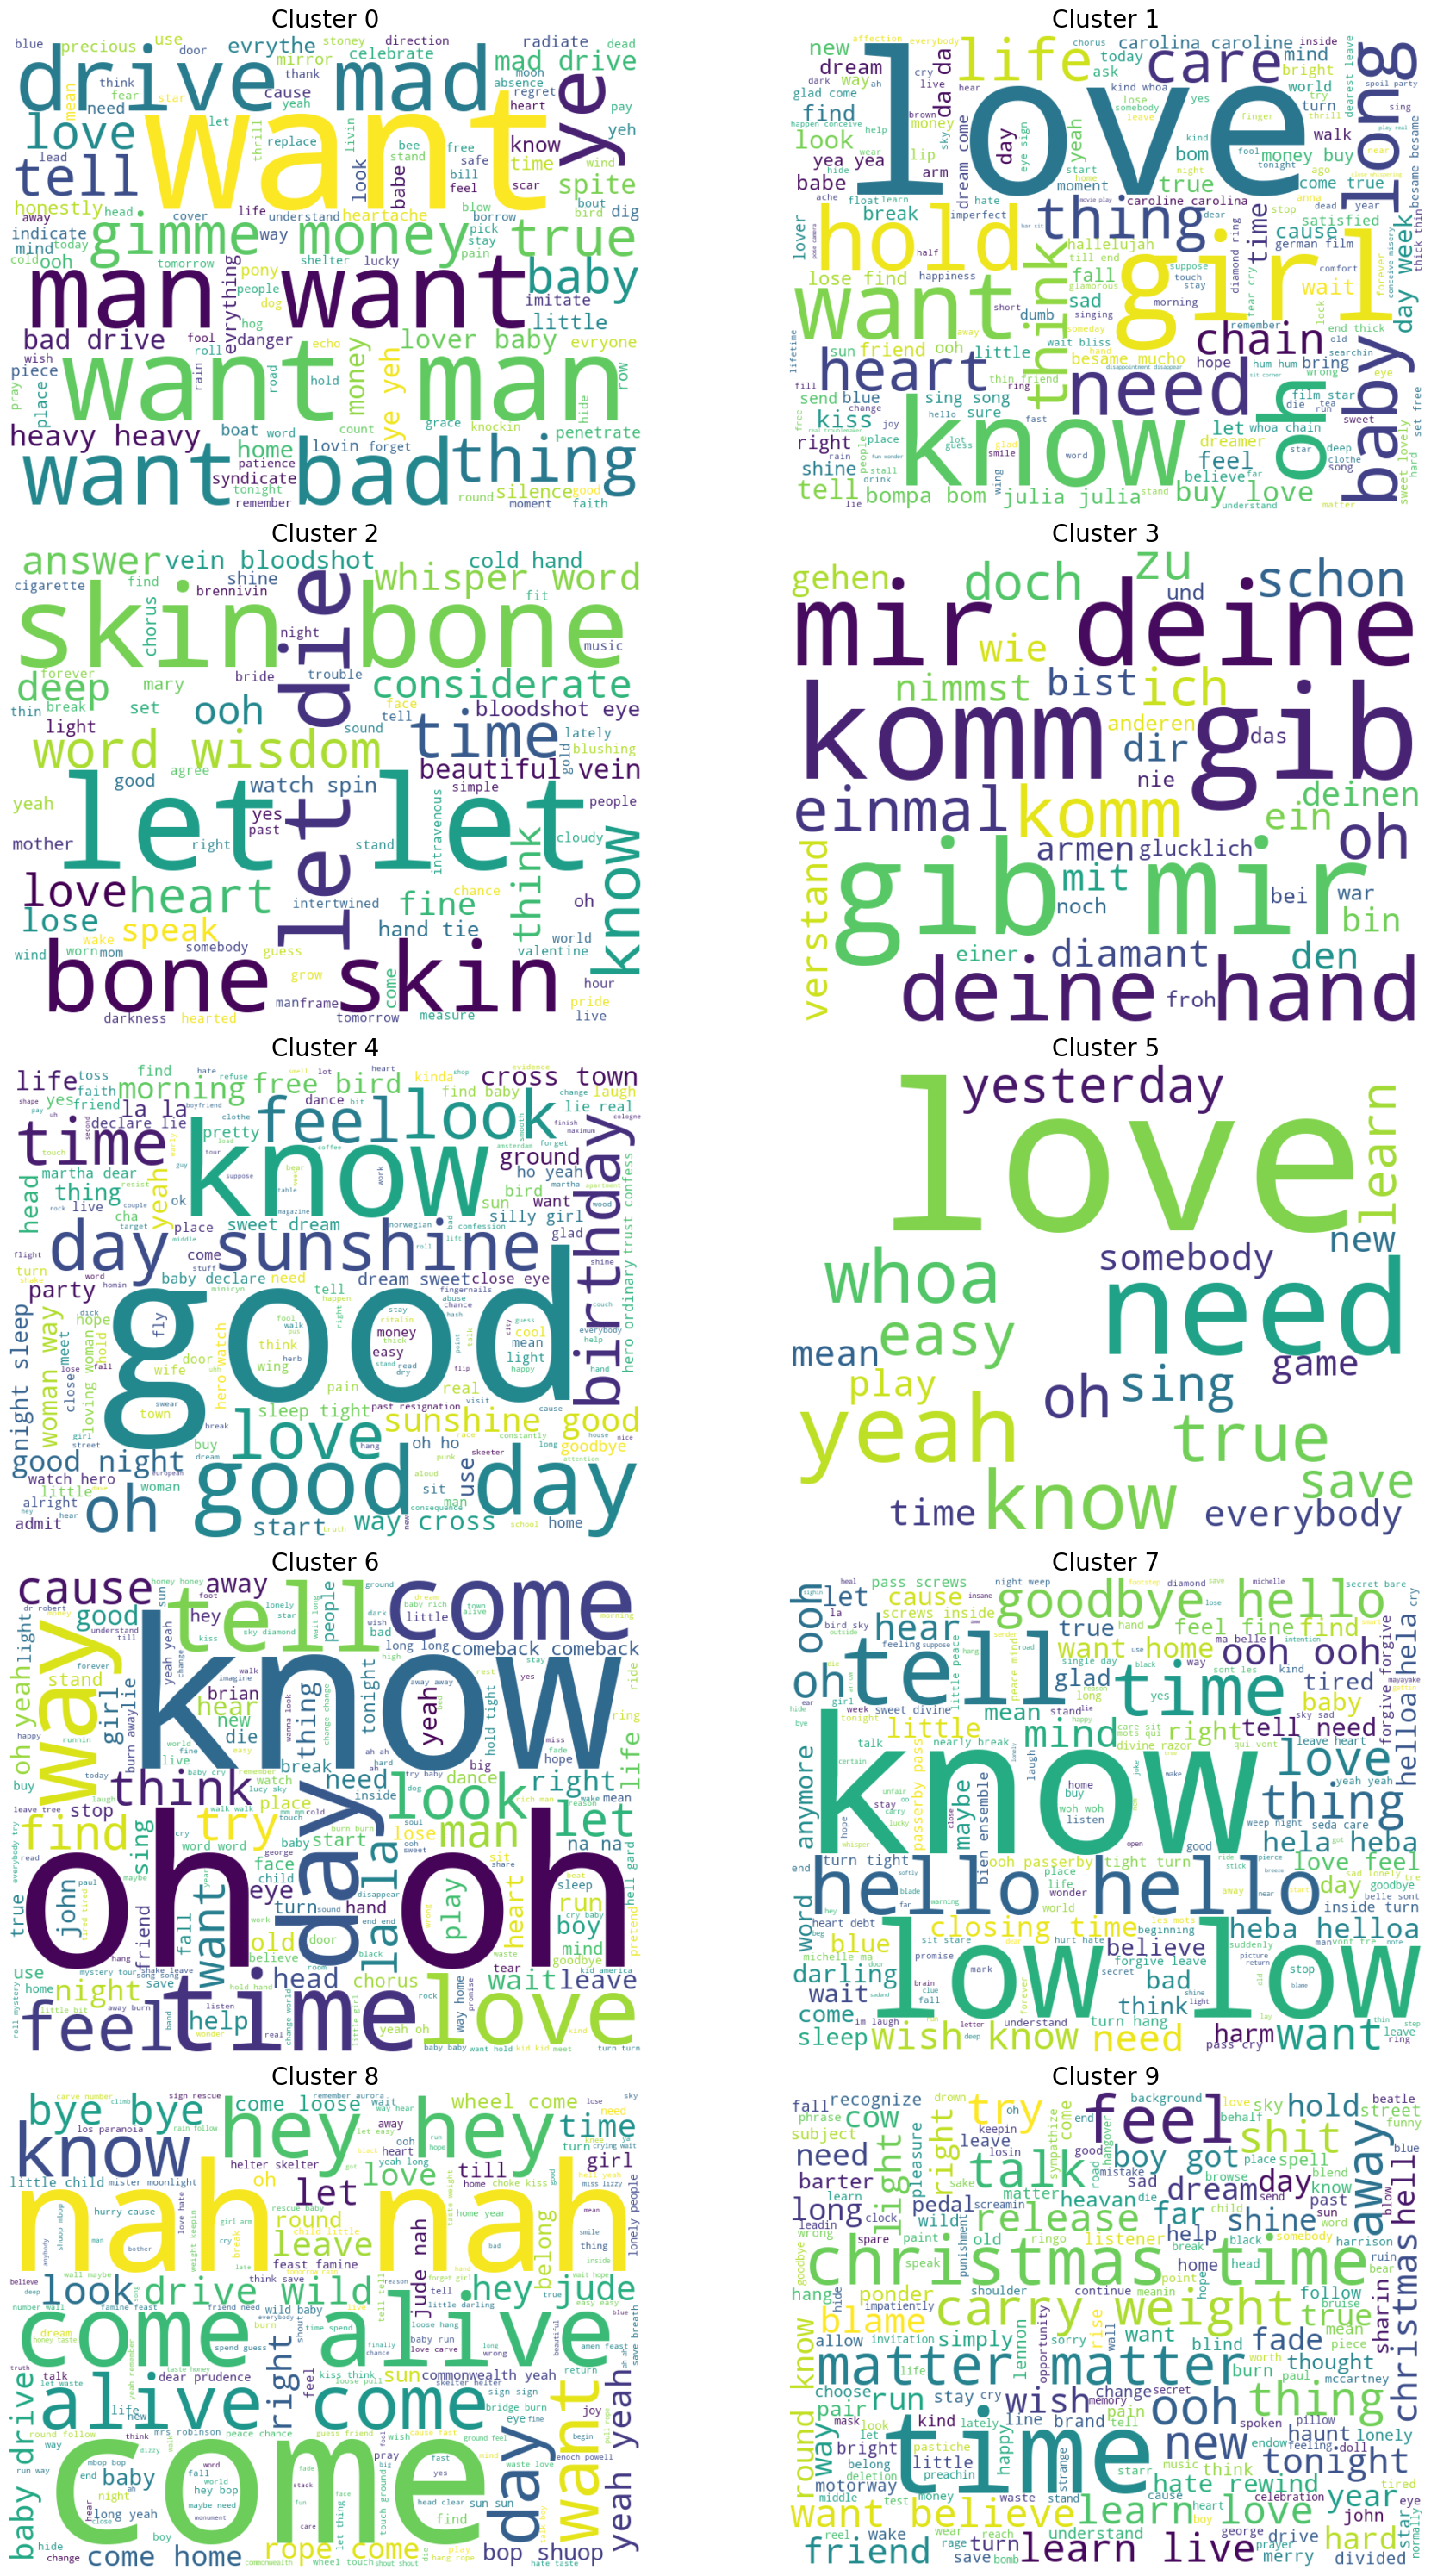

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_by_cluster = merged_df.groupby('cluster')['text'].apply(lambda x: ' '.join(x)).reset_index(name='aggregated_text')

# Step 2 & 3: Correctly Generate and Plot Word Clouds for Each Cluster
fig, axes = plt.subplots(5, 2, figsize=(20, 30))  # Adjust the layout based on the number of clusters
axes = axes.flatten()

# Iterate over each cluster and its aggregated text
for i, row in text_by_cluster.iterrows():
    cluster = row['cluster']
    aggregated_text = row['aggregated_text']

    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(aggregated_text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {cluster}', fontsize=20)

# Adjust tight_layout to handle overlapping and layout
plt.tight_layout()
plt.show()

The next part is adapted from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

In [1]:
# Assuming X is your dataset
range_n_clusters = [2, 3, 4, 10 ]

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # Set limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate and sort silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")

plt.show()

NameError: name 'plt' is not defined